## Day 35 Lecture 2 Assignment

In this assignment, we will combine what we have learned so far about classification algorithms this week.

In [1]:
!pip install scikit-optimize
!pip install xgboost

In [2]:
%matplotlib inline

import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error, plot_confusion_matrix, classification_report

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from xgboost import XGBClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
admission = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Admission_Predict.csv')

In [4]:
admission.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In this assignment, we will predict the probability of a student being admitted to a PhD program given their stats. To make the predictions, find the median for the Chance of Admit column. Create an admit column where all probabilities above the median will receive a 1 for that column and all probabilities below the median will be a zero.

Below you will process and clean the data, try the SVM classifier, the gradient boosted decision tree classifier and XGBoost, and compare your results.

Have fun!

In [5]:
def get_scores(model, X_train, X_test, y_train, y_test, verbose=False):
  if verbose:
    print(f'Training Scores: {model.score(X_train, y_train)}')
    print(f'Test Scores: {model.score(X_test, y_test)}')
  return model.score(X_train, y_train), model.score(X_test, y_test)

def get_class_report(model, X_train, X_test, y_train, y_test):
  print(f'Training Report:\n {classification_report(y_train, model.predict(X_train))}')
  print(f'Test Report:\n {classification_report(y_test, model.predict(X_test))}')

In [6]:
admission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         400 non-null    int64  
 1   GRE Score          400 non-null    int64  
 2   TOEFL Score        400 non-null    int64  
 3   University Rating  400 non-null    int64  
 4   SOP                400 non-null    float64
 5   LOR                400 non-null    float64
 6   CGPA               400 non-null    float64
 7   Research           400 non-null    int64  
 8   Chance of Admit    400 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 28.2 KB


In [7]:
admission.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,200.500000,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,115.614301,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,100.750000,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,200.500000,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,300.250000,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,400.000000,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


In [8]:
admission['is_Admit'] = np.where(admission['Chance of Admit '] >= admission['Chance of Admit '].median(), 1, 0)

In [9]:
admission['is_Admit'].value_counts()

1    204
0    196
Name: is_Admit, dtype: int64

In [10]:
X = admission.drop(['Chance of Admit ', 'is_Admit', 'Serial No.'], 1)
y = admission['is_Admit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
svc = SVC()

params = {'C': np.logspace(-1,1,3),
          'kernel': ['linear', 'poly', 'rbf'],
          'gamma': ['scale', 'auto']}

svc_grid = GridSearchCV(svc, params, cv=3)

svc_grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 0.1,  1. , 10. ]),
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [12]:
svc_grid.best_estimator_

SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
svc_grid.best_params_

{'C': 10.0, 'gamma': 'scale', 'kernel': 'linear'}

Training Scores: 0.878125
Test Scores: 0.875
Training Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       149
           1       0.89      0.88      0.88       171

    accuracy                           0.88       320
   macro avg       0.88      0.88      0.88       320
weighted avg       0.88      0.88      0.88       320

Test Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89        47
           1       0.85      0.85      0.85        33

    accuracy                           0.88        80
   macro avg       0.87      0.87      0.87        80
weighted avg       0.88      0.88      0.88        80



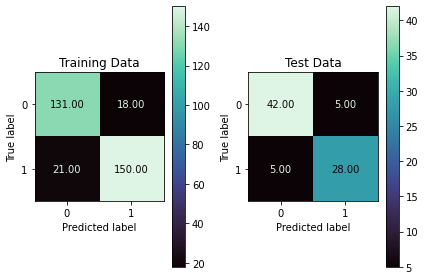

In [14]:
get_scores(svc_grid, X_train, X_test, y_train, y_test, verbose=True)
get_class_report(svc_grid, X_train, X_test, y_train, y_test)
ax1 = plt.subplot(121)
plot_confusion_matrix(svc_grid, X_train, y_train, values_format='.2f', ax=ax1, cmap='mako')
plt.title('Training Data')

ax2 = plt.subplot(122)
plot_confusion_matrix(svc_grid, X_test, y_test, values_format='.2f', ax=ax2, cmap='mako')
plt.title('Test Data')

plt.tight_layout()
plt.show()

In [15]:
gbc = GradientBoostingClassifier(n_iter_no_change=100, n_estimators=10000)

params = {'learning_rate': Real(.05, 1.0), 
          'subsample': Real(.5, 1.0), 
          'max_features': Categorical([None, 'sqrt'])}

gbc_grid = BayesSearchCV(gbc, params, cv=3)

gbc_grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=3, error_score='raise',
              estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                   criterion='friedman_mse',
                                                   init=None, learning_rate=0.1,
                                                   loss='deviance', max_depth=3,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=10000,
                                                   n_it...
    

In [16]:
gbc_grid.best_params_

OrderedDict([('learning_rate', 0.05),
             ('max_features', None),
             ('subsample', 0.9112769976349901)])

Training Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       149
           1       0.95      0.95      0.95       171

    accuracy                           0.95       320
   macro avg       0.95      0.95      0.95       320
weighted avg       0.95      0.95      0.95       320

Test Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86        47
           1       0.79      0.82      0.81        33

    accuracy                           0.84        80
   macro avg       0.83      0.83      0.83        80
weighted avg       0.84      0.84      0.84        80



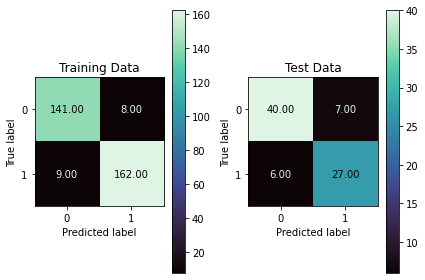

In [17]:
get_class_report(gbc_grid, X_train, X_test, y_train, y_test)
ax1 = plt.subplot(121)
plot_confusion_matrix(gbc_grid, X_train, y_train, values_format='.2f', ax=ax1, cmap='mako')
plt.title('Training Data')

ax2 = plt.subplot(122)
plot_confusion_matrix(gbc_grid, X_test, y_test, values_format='.2f', ax=ax2, cmap='mako')
plt.title('Test Data')

plt.tight_layout()
plt.show()

In [18]:
xgb = XGBClassifier(n_estimators=500)


params = {'learning_rate': Real(.05, 1.0), 
          'subsample': Real(.5, 1.0), 
          'max_features': Categorical([None, 'sqrt'])}

xgb_grid = BayesSearchCV(xgb, params, cv=3)

xgb_grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packa

BayesSearchCV(cv=3, error_score='raise',
              estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                      colsample_bylevel=1, colsample_bynode=1,
                                      colsample_bytree=1, gamma=0,
                                      learning_rate=0.1, max_delta_step=0,
                                      max_depth=3, min_child_weight=1,
                                      missing=None, n_estimators=500, n_jobs=1,
                                      nthread=None, objective='binary:logistic',
                                      random_state=0, reg_alpha=0, reg_lambda=1,
                                      sca...
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
              refit=True, return_train_score=False, scoring=None,
              search_spaces={'learning_rate': Real(low=0.05, high=1.0, prior='uniform', transform='identity'),
                             'max_features': Categ

In [19]:
xgb_grid.best_params_

OrderedDict([('learning_rate', 0.053206110818407946),
             ('max_features', 'sqrt'),
             ('subsample', 0.5000574291755245)])

Training Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       149
           1       0.98      0.98      0.98       171

    accuracy                           0.98       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.98      0.98       320

Test Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86        47
           1       0.79      0.82      0.81        33

    accuracy                           0.84        80
   macro avg       0.83      0.83      0.83        80
weighted avg       0.84      0.84      0.84        80



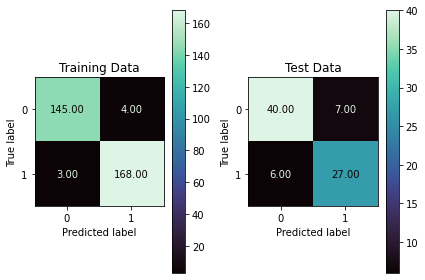

In [20]:
get_class_report(xgb_grid, X_train, X_test, y_train, y_test)
ax1 = plt.subplot(121)
plot_confusion_matrix(xgb_grid, X_train, y_train, values_format='.2f', ax=ax1, cmap='mako')
plt.title('Training Data')

ax2 = plt.subplot(122)
plot_confusion_matrix(xgb_grid, X_test, y_test, values_format='.2f', ax=ax2, cmap='mako')
plt.title('Test Data')

plt.tight_layout()
plt.show()

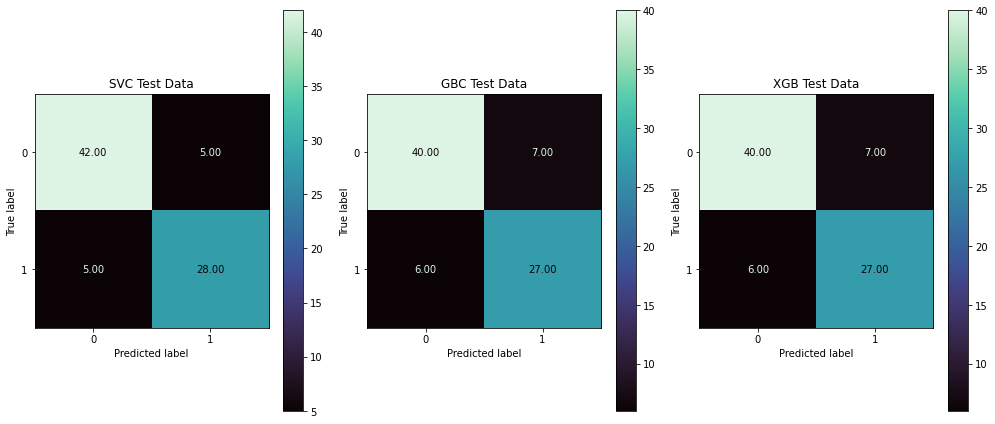

In [22]:
plt.figure(figsize=(14,6))

ax1 = plt.subplot(131)
plot_confusion_matrix(svc_grid, X_test, y_test, values_format='.2f', ax=ax1, cmap='mako')
plt.title('SVC Test Data')

ax2 = plt.subplot(132)
plot_confusion_matrix(gbc_grid, X_test, y_test, values_format='.2f', ax=ax2, cmap='mako')
plt.title('GBC Test Data')

ax3 = plt.subplot(133)
plot_confusion_matrix(xgb_grid, X_test, y_test, values_format='.2f', ax=ax3, cmap='mako')
plt.title('XGB Test Data')

plt.tight_layout()
plt.show()

The SVC is surprisingly the best model for this data. But, it also takes the longest to run and the boosted models are similiar. 